In [1]:
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq,Linear,ReLU,BatchNorm1d
from torch_scatter import scatter_mean

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from InteractionNetwork import InteractionNetwork

<hr>
load pretrained model

In [2]:
model=InteractionNetwork()
model.load_state_dict(torch.load("../data/model/IN_sythesized.pth"))

<All keys matched successfully>

end of load pretrained model
<hr>
get data

In [52]:
b=torch.load("../data/test_sytehsized.pt")
g=b[1]
g.batch=torch.tensor(np.zeros(g.x.shape[0]).astype("int64"))
g

Data(batch=[10], edge_index=[2, 90], x=[10, 48], y=[1, 2])

end of get data<hr>

functions copied from `src.util`

In [53]:
def copy_layer(layer):
    """
    create a deep copy of provided layer
    """
    layer_cp=eval("nn."+layer.__repr__())
    layer_cp.load_state_dict(layer.state_dict())
    
    return layer_cp

In [54]:
copy_tensor=lambda x: torch.tensor(x.clone().detach().numpy(),requires_grad=True,dtype=torch.float32)

In [55]:
for i in (model.interactionnetwork.children()):
    for n,j in i.named_modules():
        if n and n[-1].isnumeric() and ("." in n):
            print(n,j.__repr__())

edge_mlp.0 Linear(in_features=96, out_features=128, bias=True)
edge_mlp.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
edge_mlp.2 ReLU()
edge_mlp.3 Linear(in_features=128, out_features=128, bias=True)
node_mlp_1.0 Linear(in_features=176, out_features=128, bias=True)
node_mlp_1.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
node_mlp_1.2 ReLU()
node_mlp_1.3 Linear(in_features=128, out_features=128, bias=True)
node_mlp_2.0 Linear(in_features=176, out_features=128, bias=True)
node_mlp_2.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
node_mlp_2.2 ReLU()
node_mlp_2.3 Linear(in_features=128, out_features=128, bias=True)
global_mlp.0 Linear(in_features=128, out_features=128, bias=True)
global_mlp.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
global_mlp.2 ReLU()
global_mlp.3 Linear(in_features=128, out_features=2, bias=True)


layer name `n` ends with 0-2 -> joint together, rectified linear layer
layer name `n` ends with 3 -> standalone linear layer

`R2` (`node_mlp_1.0-2`) and `R4` (`node_mlp_2.0-2`) contains partial relevance score of input `x`

In [56]:
layers={}
cnt=0
for i in (model.interactionnetwork.children()):
    layer=[]
    for n,j in i.named_modules():
        if n and n[-1].isnumeric() and ("." in n):
            if n[-1] in ["0","1","2"]:
                layer.append(copy_layer(j))
            else:
                layers[f"L{cnt}"]=Seq(*layer)
                layer=[]
                cnt+=1
                
                layers[f"L{cnt}"]=copy_layer(j)
                cnt+=1
layers

{'L0': Sequential(
   (0): Linear(in_features=96, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L1': Linear(in_features=128, out_features=128, bias=True),
 'L2': Sequential(
   (0): Linear(in_features=176, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L3': Linear(in_features=128, out_features=128, bias=True),
 'L4': Sequential(
   (0): Linear(in_features=176, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L5': Linear(in_features=128, out_features=128, bias=True),
 'L6': Sequential(
   (0): Linear(in_features=128, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L7': Linear(in_features=128, out_features=2, bias=True)}

In [57]:
row,col=g.edge_index
n_tracks=g.x.shape[0]
x=nn.BatchNorm1d(48)(g.x)
x=copy_tensor(torch.cat([x[row],x[col]],1))

In [58]:
activations={}
activations["a0"]=layers["L0"].forward(x)

In [59]:
M_col=torch.zeros(col.shape[0],n_tracks,dtype=torch.float32)
for i,j in enumerate(col):
    M_col[i,j]=1
M_col=M_col.T

In [60]:
M_row=torch.zeros(row.shape[0],n_tracks,dtype=torch.float32)
for i,j in enumerate(row):
    M_row[i,j]=1
M_row=M_row.T

In [61]:
for i in range(1,len(layers.keys())):
    if i==2:
        #a1->a1'
        a=copy_tensor(torch.cat([g.x[row],activations[f"a{i-1}"]],1))           # [x[row],a1]
    elif i==4:
        #a3->a3'
#         a=copy_tensor(torch.cat([g.x,M_col@activations[f"a{i-1}"]/n_tracks],1)) # g.x,scatter_mean(a3,col,dim=0)
        a=copy_tensor(torch.cat([g.x,
                                 scatter_mean(activations[f"a{i-1}"], col, dim=0, dim_size=g.x.size(0))
                                ],1)) # g.x,scatter_mean(a3,col,dim=0)
    elif i==6:
        #a5->a5'
        layers[f"L{i}"].eval()
        a=copy_tensor(scatter_mean(activations[f"a{i-1}"],g.batch,dim=0))   # mean of all tracks
    else:
        a=copy_tensor(activations[f"a{i-1}"])
    
    activations[f"a{i}"]=layers[f"L{i}"].forward(a)

In [62]:
for k in activations.keys():
    print(k,activations[k].shape)

a0 torch.Size([90, 128])
a1 torch.Size([90, 128])
a2 torch.Size([90, 128])
a3 torch.Size([90, 128])
a4 torch.Size([10, 128])
a5 torch.Size([10, 128])
a6 torch.Size([1, 128])
a7 torch.Size([1, 2])


In [63]:
u=activations["a7"]

R={}
R[f"R{8}"]=copy_tensor(u@torch.tensor([[0,0],[0,1]],dtype=torch.float32))
R

{'R8': tensor([[ 0.0000, -2.5398]], requires_grad=True)}

In [64]:
def LRP(a,l,r,epsilon=1e-9):
    a=torch.tensor(a.clone().detach().numpy(),
                      requires_grad=True,dtype=torch.float32)
    a.retain_grad()
    
    z=l.forward(a)
    s=r/(z+epsilon)
    
    (z*s.data).sum().backward()
    c=a.grad
    
    return a*c

In [65]:
activations["a-1"]=x

for i in range(len(layers.keys())-1,-1,-1):
    a=activations[f"a{i-1}"]
    r=R[f"R{i+1}"]
    l=layers[f"L{i}"]
  
    if i==2:
        # a1->a1'
        a=copy_tensor(torch.cat([g.x[row],a],1))
        r=LRP(a,l,r)
        
        # r_x[row],r2'
        r_src,r=r[:,:48],r[:,48:] 
        R[f"R{i}_src"]=r_src

    elif i==4:
        # a3->a3'
        a=copy_tensor(torch.cat([g.x,M_col@a/n_tracks],1))
        r=LRP(a,l,r)
        
        r_x,r=r[:,:48],r[:,48:]
        R[f"R{i}_x"]=r_x
        r=r[col]/n_tracks
    elif i==6:
        # a5->a5'
        a=copy_tensor((torch.ones(1,n_tracks)@a/n_tracks))
        r=LRP(a,l,r)
        
    else:
        a=copy_tensor(a)
        r=LRP(a,l,r)
        
    R[f"R{i}"]=r

In [66]:
for k in R.keys():
    print(k,R[k].shape,R[k].sum())

R8 torch.Size([1, 2]) tensor(-2.5398, grad_fn=<SumBackward0>)
R7 torch.Size([1, 128]) tensor(-2.2044, grad_fn=<SumBackward0>)
R6 torch.Size([1, 128]) tensor(6.3145, grad_fn=<SumBackward0>)
R5 torch.Size([10, 128]) tensor(72.5457, grad_fn=<SumBackward0>)
R4_x torch.Size([10, 48]) tensor(-12.3677, grad_fn=<SumBackward0>)
R4 torch.Size([90, 128]) tensor(11.1309, grad_fn=<SumBackward0>)
R3 torch.Size([90, 128]) tensor(38.3843, grad_fn=<SumBackward0>)
R2_src torch.Size([90, 48]) tensor(141.7351, grad_fn=<SumBackward0>)
R2 torch.Size([90, 128]) tensor(-141.7352, grad_fn=<SumBackward0>)
R1 torch.Size([90, 128]) tensor(-141.7354, grad_fn=<SumBackward0>)
R0 torch.Size([90, 96]) tensor(-0.0008, grad_fn=<SumBackward0>)


In [67]:
R["R0"]

tensor([[ 1.3825e+00,  9.2916e-02,  4.7445e-02,  ..., -3.3017e-01,
          1.0863e+00, -1.6913e-03],
        [ 9.9386e-01,  2.0915e-01, -6.2826e-03,  ...,  4.8551e-01,
         -2.4719e-01,  2.2526e-01],
        [ 1.4031e+00,  1.4675e-01, -5.0228e-03,  ..., -2.9452e-01,
          6.2283e-01, -2.3496e-01],
        ...,
        [ 2.6877e-01,  2.0265e-01, -1.0716e+00,  ..., -3.4730e+00,
         -4.2711e-01, -3.8195e-02],
        [ 3.1026e-02,  5.4917e-02, -1.0785e-01,  ...,  2.9186e-01,
          1.1257e+00,  2.1162e-01],
        [ 5.8886e-01,  5.1097e-01, -1.1083e+00,  ...,  2.0439e+00,
          1.2681e+00, -6.0768e-01]], grad_fn=<MulBackward0>)

In [68]:
r=(((M_row@R["R0"][:,:48]))+(M_row@R["R2_src"])+R["R4_x"])
r.shape,r.sum()

(torch.Size([10, 48]), tensor(1026.7058, grad_fn=<SumBackward0>))

<hr>

## Plot

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [70]:
sns.set(style="white")

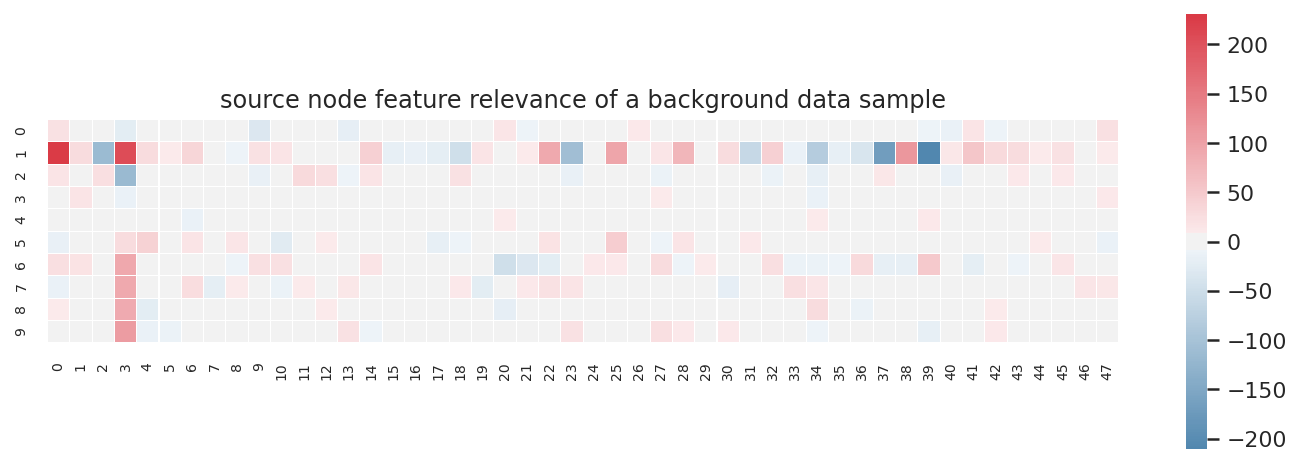

In [71]:
val=r.detach().cpu().numpy()
df=pd.DataFrame(val,columns=np.arange(48))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
s=sns.heatmap(df, cmap=cmap, center=0,xticklabels=1,
            square=True, linewidths=0.01, cbar_kws={"shrink": .5})

s.tick_params(labelsize=7)

if g.y[:,1]>0:
    plt.title("source node feature relevance of a signal data sample")
else:
    plt.title("source node feature relevance of a background data sample")

plt.show()